# Heart Failure Prediction
Please see the corresponding [kaggle](https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci) link for the details.

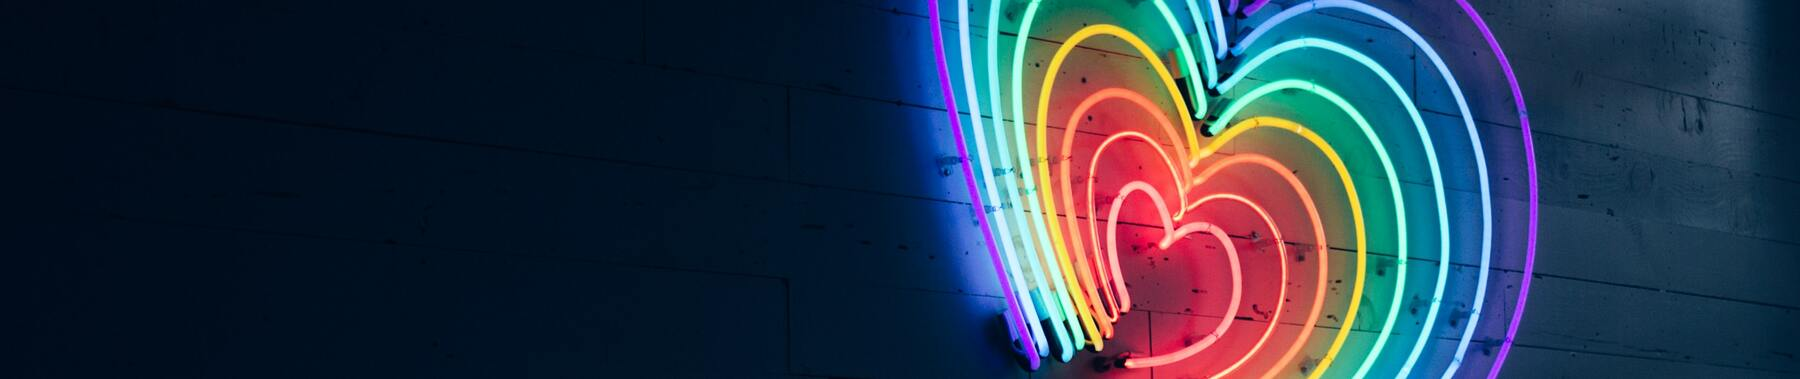

## Approach: decision trees

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 14})

In [3]:
data = pd.read_csv("heart_disease.csv")
data.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,0,145,233,1,2,150,0,2.3,2,0,2,0
1,67,1,3,160,286,0,2,108,1,1.5,1,3,1,1
2,67,1,3,120,229,0,2,129,1,2.6,1,2,3,1
3,37,1,2,130,250,0,0,187,0,3.5,2,0,1,0
4,41,0,1,130,204,0,2,172,0,1.4,0,0,1,0


## Let us evaluate the data a little bit

In [3]:
print(f"total data shape: {data.shape}")

nums = []# unique possibilities for each feature
for feature in data.columns:
    num = len(data.loc[:,feature].unique())
    nums.append(num)
    print(f"feature {feature:20s}: unique values = {num}")

total data shape: (303, 14)
feature age                 : unique values = 41
feature sex                 : unique values = 2
feature cp                  : unique values = 4
feature trestbps            : unique values = 50
feature chol                : unique values = 152
feature fbs                 : unique values = 2
feature restecg             : unique values = 3
feature thalach             : unique values = 91
feature exang               : unique values = 2
feature oldpeak             : unique values = 40
feature slope               : unique values = 3
feature ca                  : unique values = 4
feature thal                : unique values = 3
feature target              : unique values = 2


### One-hot encoding
We first translate categorical features with more than 2 classes into several binary features.

In [4]:
cat_features = ['cp','restecg','slope','ca','thal']
print(f"The multiclass categorical features are:\n{cat_features}")
dataOHE = pd.get_dummies(data = data, prefix = cat_features, columns = cat_features)

print(f"modified data shape: {dataOHE.shape}")
print(f"number of features: {dataOHE.shape[1]-1}")
print(f"number of examples: {dataOHE.shape[0]}")

dataOHE.head(5)

The multiclass categorical features are:
['cp', 'restecg', 'slope', 'ca', 'thal']
modified data shape: (303, 26)
number of features: 25
number of examples: 303


,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,target,cp_0,...,slope_0,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,1,...,0,0,1,1,0,0,0,0,1,0
1,67,1,160,286,0,108,1,1.5,1,0,...,0,1,0,0,0,0,1,1,0,0
2,67,1,120,229,0,129,1,2.6,1,0,...,0,1,0,0,0,1,0,0,0,1
3,37,1,130,250,0,187,0,3.5,0,0,...,0,0,1,1,0,0,0,1,0,0
4,41,0,130,204,0,172,0,1.4,0,0,...,1,0,0,1,0,0,0,1,0,0


In [5]:
features = [x for x in dataOHE.columns if x != 'target'] ## Removing our target variable
print(f"total number of features after one-hot encoding: {len(features)}")

total number of features after one-hot encoding: 25


### Split the data using Scikit-learn

In [6]:
X_train, X_dev, y_train, y_dev = train_test_split(dataOHE[features],dataOHE['target'],train_size=0.8, random_state=1)
print(f"X_train.shape = {X_train.shape}, X_dev.shape = {X_dev.shape}")
print(f"y_train.shape = {y_train.shape}, y_dev.shape = {y_dev.shape}")

X_train.shape = (242, 25), X_dev.shape = (61, 25)
y_train.shape = (242,), y_dev.shape = (61,)


## XGBoost

In [7]:
n_estimators = 100 # default val (number of decision trees in the ensemble)
early_stopping_rounds = 20 # patience on stopping criteria
learning_rate = 0.1 # learning rate of the Gradient Descent
max_depth = 6 # max depth of the trees
lambda_ = 0 # regularization parameter
model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate,
                      verbosity = 0, random_state = 1, early_stopping_rounds = early_stopping_rounds,
                      max_depth = max_depth,alpha=lambda_)
model.fit(X_train,y_train, eval_set = [(X_dev,y_dev)],verbose=False)

from sklearn.metrics import accuracy_score # the same np.mean(yhat==y)*100
print(f"train: Accuracy score: {accuracy_score(model.predict(X_train),y_train)*100:.2f}%")
print(f"dev  : Accuracy score: {accuracy_score(model.predict(X_dev),y_dev)*100:.2f}%")

train: Accuracy score: 99.59%
dev  : Accuracy score: 80.33%


### Analysis
The model clearly suffers from overfitting!

### Investigate the impact of regularization parameter

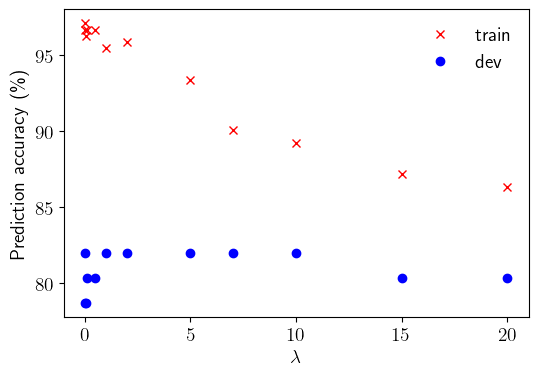

In [8]:
lambdas = [0, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 7, 10, 15, 20]
max_depth = 4
n_estimators = 100
train_acc = []
dev_acc = []
for lambda_ in lambdas:
    model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate,
                      verbosity = 0, random_state = 1, early_stopping_rounds = early_stopping_rounds,
                      max_depth = max_depth, alpha=lambda_)
    model.fit(X_train,y_train, eval_set = [(X_dev,y_dev)],verbose=False)
    train_acc.append(accuracy_score(model.predict(X_train),y_train)*100)
    dev_acc.append(accuracy_score(model.predict(X_dev),y_dev)*100)
    


plt.figure(figsize=(6,4))
plt.plot(lambdas,train_acc,'xr',label='train')
plt.plot(lambdas,dev_acc,'ob',label='dev')
plt.xlabel('$\lambda$')
plt.ylabel('Prediction accuracy (\%)')
plt.legend(frameon=False)
plt.show()

### Analysis
It appears that $\lambda=10$ provides the best outcome.

### Investigate the impact of max depth

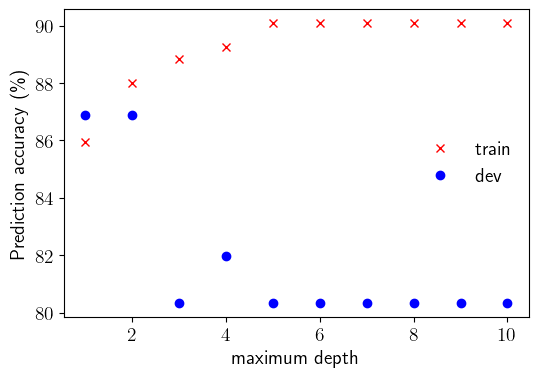

In [9]:
lambda_ = 10
max_depths = range(1,11)
n_estimators = 100
train_acc = []
dev_acc = []
for max_depth in max_depths:
    model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate,
                      verbosity = 0, random_state = 1, early_stopping_rounds = early_stopping_rounds,
                      max_depth = max_depth, alpha=lambda_)
    model.fit(X_train,y_train, eval_set = [(X_dev,y_dev)],verbose=False)
    train_acc.append(accuracy_score(model.predict(X_train),y_train)*100)
    dev_acc.append(accuracy_score(model.predict(X_dev),y_dev)*100)
    

plt.figure(figsize=(6,4))
plt.plot(max_depths,train_acc,'xr',label='train')
plt.plot(max_depths,dev_acc,'ob',label='dev')
plt.xlabel('maximum depth')
plt.ylabel('Prediction accuracy (\%)')
plt.legend(frameon=False)
plt.show()

### Analysis
Clearly, a maximum depth of $2$ provides the best outcome. So, we set $\lambda=10$ and maximum depth equal to $2$. 

In [11]:
max_depth = 2
lambda_ = 10
n_estimators = 100
early_stopping_rounds = 20
learning_rate = 0.1

model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate,
                      verbosity = 0, random_state = 1, early_stopping_rounds = early_stopping_rounds,
                      max_depth = max_depth,alpha=lambda_)
model.fit(X_train,y_train, eval_set = [(X_dev,y_dev)],verbose=False)

from sklearn.metrics import accuracy_score # the same np.mean(yhat==y)*100
print(f"train: Accuracy score: {accuracy_score(model.predict(X_train),y_train)*100:.2f}%")
print(f"dev  : Accuracy score: {accuracy_score(model.predict(X_dev),y_dev)*100:.2f}%")

train: Accuracy score: 88.02%
dev  : Accuracy score: 86.89%
